In [1]:
!python -V

Python 3.7.10


In [2]:
# Import basic python packages you will need to run this script
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import scipy
from imageio import imread

import skimage.io as io
import skimage.transform as trans
import cv2 as cv

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/pb183/opt/anaconda3/envs/py37/lib

In [3]:
# added plaidML setup code for using AMD Radeon GPU on the iMac
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [4]:
# import all the important loss, model, optimizing functions and more from tensorflow w/keras backend
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

import keras
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from keras.layers.noise import GaussianDropout

In [5]:
# direct to the appropriate directory where you images an ground truth masks lives
shared_path = '/Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/'  #modify as needed
image_path = shared_path+'Training_bitmaps/' #modify to direct to right folder
mask_path = shared_path+'Training_masks/' #modify to direct to right folder

# new folder path for test images 
testset_path = shared_path          
testimage_path = testset_path+'Validation_bitmaps/'       
testmask_path = testset_path+'Validation_masks/'       

In [6]:
# this looks for all files in the image and mask paths that are bitmpap files and saves their filenames in these arrays
included_extensions = ['bmp']
file_names_images = [fn for fn in os.listdir(image_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

file_names_masks = [fn for fn in os.listdir(mask_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

file_names_testimages = [fn for fn in os.listdir(testimage_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

file_names_testmasks = [fn for fn in os.listdir(testmask_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

In [7]:
# this is just a check to make sure that the number of images and masks match up
print(len(file_names_images))
print(len(file_names_masks))
print(len(file_names_testimages))
print(len(file_names_testmasks))

840
840
359
359


In [8]:
# define size of images and starting positions for cropping (if you need to crop)
# if not cropping the original images and masks, then make sure that the crop line in the for loop below is commented out
size = 256
images = np.zeros((len(file_names_images),size,size, 1)).astype('float')
testimages = np.zeros((len(file_names_testimages),size,size, 1)).astype('float')
starty = 160
cropx = 256
cropy = 256
startx = 130

# import bitmap images into arrays
for i in range(len(file_names_images)):
    image = imread(image_path+file_names_images[i], as_gray=True)/255
    image = image[starty:starty+cropy,startx:startx+cropx]
    image = image[..., None] # adds a channel layer
    images[i] = image # adds subsequent image arrays to img matrix

# import test bitmap images into arrays
for i in range(len(file_names_testimages)):
    testimage = imread(testimage_path+file_names_testimages[i], as_gray=True)/255
    testimage = testimage[starty:starty+cropy,startx:startx+cropx]
    testimage = testimage[..., None] # adds a channel layer
    testimages[i] = testimage # adds subsequent image arrays to img matrix

# verify number of images and shape
print(images.shape)
print(testimages.shape)

(840, 256, 256, 1)
(359, 256, 256, 1)


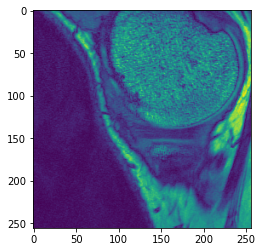

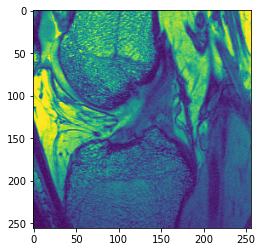

In [9]:
# display a sample image from images array
plt.imshow(np.sum(images[90],axis=2))
plt.show()
plt.imshow(np.sum(testimages[1],axis=2))

(840, 256, 256, 1)
(359, 256, 256, 1)


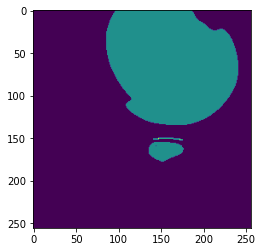

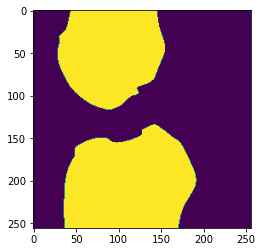

In [10]:
# import ground truth masks into arrays
mask = np.zeros((len(file_names_images), size, size, 1)).astype('float')
for i in range(len(file_names_images)):
    segmask = imread(mask_path+file_names_masks[i], as_gray=True)/255
    #minimum = segmask.min()
    segmask = np.where(segmask>0.75, 2, (np.where(segmask<0.25, 0, 1)))  #this takes my input background, bone, and cartilage pixels equal to 0,1,2
    segmask = segmask[starty:starty+cropy,startx:startx+cropx]
    segmask = segmask[..., None]
    mask[i] = segmask # adds subsequent image arrays to img matrix
    
# import test ground truth masks into arrays
testmask = np.zeros((len(file_names_testmasks), size, size, 1)).astype('float')
for i in range(len(file_names_testmasks)):
    testsegmask = imread(testmask_path+file_names_testmasks[i], as_gray=True)/255
    #testminimum = testsegmask.min()
    testsegmask = np.where(testsegmask>0.75, 2, (np.where(testsegmask<0.25, 0, 1)))
    testsegmask = testsegmask[starty:starty+cropy,startx:startx+cropx]
    testsegmask = testsegmask[..., None]
    testmask[i] = testsegmask # adds subsequent image arrays to img matrix

# verify number of images and shape
print(mask.shape)
print(testmask.shape)
plt.imshow(np.sum(mask[90],axis=2))
plt.show()
plt.imshow(np.sum(testmask[1],axis=2))

In [11]:
# define the data as categorical (turns the data from [:,:,:,1] to [:,:,:,3])
from keras.utils import to_categorical
mask_cat = to_categorical(mask,num_classes=3)
testmask_cat = to_categorical(testmask,num_classes=3)

print(mask_cat.shape)
print(testmask_cat.shape)

(840, 256, 256, 3)
(359, 256, 256, 3)


In [12]:
# flatten training data
mask_flattened = mask.flatten()
#print(mask_flattened.shape)

# create class weights because the data is highly unbalanced
#####
# unused when using dice coef loss
#####
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(mask_flattened),mask_flattened)

print('class weights = ',class_weights, 'Note: Background, bone, cartilage')

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0. 1. 2.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


class weights =  [  0.45565655   1.24594526 362.17024888] Note: Background, bone, cartilage


In [13]:
# these are functions for pairing the image to its respective mask
def get_dataset(images, mask, batch_size):
    dataset_input = tf.data.Dataset.from_tensor_slices(tf.constant(images, dtype=tf.float32)) #converts to tf type
    dataset_mask = tf.data.Dataset.from_tensor_slices(tf.constant(mask, dtype=tf.float32)) #converts to tf type

    dataset_input = dataset_input.map(lambda x: tf.image.per_image_standardization(x)) #standardizes the image
    dataset_input = dataset_input.map(lambda x: tf.image.adjust_contrast(x,1.2)) #adds some contrast

    dataset = tf.data.Dataset.zip((dataset_input, dataset_mask)) #pairs the images to the masks into one tf array
    dataset = dataset.shuffle(len(images)).repeat() #randomly shuffles dataset and repeats the dataset
    dataset = dataset.batch(batch_size).prefetch(batch_size) # set the batch size
    print('image shape: ', dataset.output_shapes[0])
    print('label shape: ', dataset.output_shapes[1])
    print('types: ', dataset.output_types)
    print()
    print(dataset)
    return dataset

#this does the same as get_dataset but does not shuffle the images. used for displaying results
def get_dataset_noshuffle(images, mask, batch_size):
    dataset_input = tf.data.Dataset.from_tensor_slices(tf.constant(images, dtype=tf.float32))
    dataset_mask = tf.data.Dataset.from_tensor_slices(tf.constant(mask, dtype=tf.float32))

    dataset_input = dataset_input.map(lambda x: tf.image.per_image_standardization(x))
    dataset_input = dataset_input.map(lambda x: tf.image.adjust_contrast(x,1.2))

    dataset = tf.data.Dataset.zip((dataset_input, dataset_mask))
    dataset = dataset.batch(batch_size).prefetch(batch_size)
    print('image shape: ', dataset.output_shapes[0])
    print('label shape: ', dataset.output_shapes[1])
    print('types: ', dataset.output_types)
    print()
    print(dataset)
    return dataset

In [14]:
# randomly splits the whole dataset into a training and test set. change the test_size to a different value between 0 and 1 to make it smaller/bigger
X_train, X_test, y_train, y_test = train_test_split(images, mask_cat, test_size=0.0001, random_state=42)
X_test = testimages # if you want to use a separate set of images that you imported earlier then use this
y_test = testmask_cat # and this

In [15]:
print(X_train.shape)
print(X_test.shape)

(839, 256, 256, 1)
(359, 256, 256, 1)


In [16]:
print(y_train.shape)
print(y_test.shape)

(839, 256, 256, 3)
(359, 256, 256, 3)


In [17]:
# use the get_dataset function to pair the X_train with y_train and X_test with y_test. adjust batch size as needed
train_dataset = get_dataset(X_train, y_train, 16)
test_dataset = get_dataset(X_test, y_test, 4)
test_dataset_noshuffle = get_dataset_noshuffle(X_test, y_test, 4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
image shape:  (?, 256, 256, 1)
label shape:  (?, 256, 256, 3)
types:  (tf.float32, tf.float32)

<DatasetV1Adapter shapes: ((?, 256, 256, 1), (?, 256, 256, 3)), types: (tf.float32, tf.float32)>
image shape:  (?, 256, 256, 1)
label shape:  (?, 256, 256, 3)
types:  (tf.float32, tf.float32)

<DatasetV1Adapter shapes: ((?, 256, 256, 1), (?, 256, 256, 3)), types: (tf.float32, tf.float32)>
image shape:  (?, 256, 256, 1)
label shape:  (?, 256, 256, 3)
types:  (tf.float32, tf.float32)

<DatasetV1Adapter shapes: ((?, 256, 256, 1), (?, 256, 256, 3)), types: (tf.float32, tf.float32)>


In [18]:
# loss function --> dice_coef_multilabel just sums the dice coef over the number of classes

smooth = 1.
dropout_rate = 0.5
act = 'relu'

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=3):
    dice=0
    for index in range(3):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice

def dice_coef_multilabel_loss(y_true, y_pred):
    return 3. - dice_coef_multilabel(y_true, y_pred)

In [19]:
# following unet model is from https://github.com/zhixuhao/unet/blob/master/model.py
def unet(n_classes = 3, pretrained_weights = None,input_size = (size,size,1), df=8, kernel_size = 5): #modify input image size here
    inputs = Input(input_size)
    conv1 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(df*2*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(df*2*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(df*2*2*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3) 
    conv6 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(df*2*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(df*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(df, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(n_classes, (1,1), activation = 'softmax')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_multilabel_loss, metrics = ['accuracy'])
    
    model.summary() #if you want to printout all the parameters and model summary 

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [20]:
# run the actual unet function - change the deg of freedom here. change the input or image size as needed here
model = unet(pretrained_weights=None, df=8, input_size=(size, size, 1), kernel_size=5)
y = model.count_params() # counts the number of aparameters in the model you just created with the specs you defined

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  208         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  1608        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [21]:
x = len(X_train)*size*size # counting all the number of pixels in the entire training image set
x/y 

43.27504059147465

In [22]:
# set your batch size. 
batch_size = 16
batch_size_test = 4 
steps_epoch = np.int16(np.ceil(len(X_train)/batch_size)) # determines your steps per epoch
steps_val = np.int16(np.ceil(len(X_test)/batch_size_test)) # determines your steps for the test set

In [23]:
# update the file name for the saved weights 
model_checkpoint = ModelCheckpoint('Multiclass_weights_df8_trainbatch16_testbatch4_ep15_dice_coef_loss.hdf5', monitor='loss',
                                   verbose=1, save_best_only=True)

#This is the actual training part of the code
history = model.fit(train_dataset, validation_data=test_dataset,steps_per_epoch=steps_epoch, 
                    validation_steps=steps_val, batch_size=batch_size, epochs=15, verbose=1, callbacks=[model_checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
52/53 [============================>.] - ETA: 4s - loss: 1.7603 - acc: 0.7443
Epoch 00001: loss improved from inf to 1.75897, saving model to Multiclass_weights_df8_trainbatch16_testbatch4_ep15_dice_coef_loss.hdf5
53/53 [==============================] - 332s 6s/step - loss: 1.7590 - acc: 0.7439 - val_loss: 1.6686 - val_acc: 0.7653
Epoch 2/15
52/53 [============================>.] - ETA: 4s - loss: 1.4058 - acc: 0.8737
Epoch 00002: loss improved from 1.75897 to 1.40129, saving model to Multiclass_weights_df8_trainbatch16_testbatch4_ep15_dice_coef_loss.hdf5
53/53 [==============================] - 275s 5s/step - loss: 1.4013 - acc: 0.8747 - val_loss: 1.2599 - val_acc: 0.9071
Epoch 3/15
52/53 [============================>.] - ETA: 4s - loss: 1.1339 - acc: 0.9489
Epoch 00003: loss improved from 1.40129 to 1.13354, saving model to Multiclass_weights_df8_trainbatch16_testbatch4_ep15_dice_coef_loss.hdf5
53/53 [======================

In [24]:
# copy and paste the weights hdf5 file that had the lowest loss. apply trained weights to test data
model.load_weights('Multiclass_weights_df8_trainbatch16_testbatch4_ep15_dice_coef_loss.hdf5')
results = model.predict(test_dataset_noshuffle, batch_size=batch_size_test, verbose=1, steps=steps_val)

90/90 [==============================] - 43s 475ms/step


In [25]:
# this is just a function to display a bunch of images in small tiles
def plot_examples(batch):
    plt.figure(figsize=(15, 15))
    for i in range(len(batch)):
        plt.subplot(12, 8, i+1)
        plt.imshow(batch[i])
#         plt.colorbar()
#         plt.axis('off')
        plt.gray()
    plt.show()

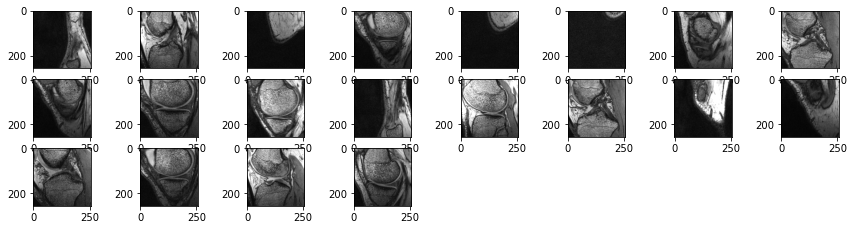

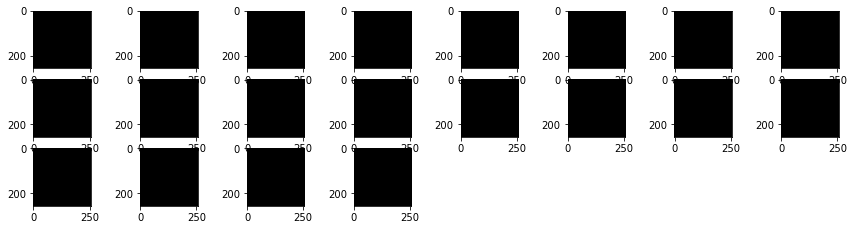

In [26]:
plot_examples(np.sum(X_test[0:20],axis=3)) # display the test images
plot_examples(np.sum(y_test[0:20],axis=3)) # display the test masks

(359, 256, 256, 3)
[0.0000000e+00 1.1755086e-38 1.1755260e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
(359, 256, 256)


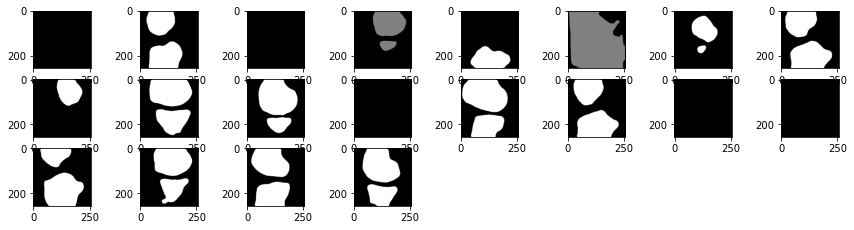

47054881
0
23527391
16366181.0
7160620.5
635.40106
(359, 256, 256)


In [92]:
print(results.shape)
results_argmax = np.argmax(results, axis=3)
plot_examples(results_argmax[0:20])

In [43]:
results_argmax.shape
#results_thresh = np.zeros((len(results), size, size, 1)).astype('float')
results_thresh = results_argmax
threshold_val_high = 0.67
threshold_val_low = 0.33
threshold_indices_1 = results_thresh > threshold_val_high
threshold_indices_05 = (results_thresh >= threshold_val_low) & (results_thresh <= threshold_val_high)
threshold_indices_0 = results_thresh < threshold_val_low
results_thresh[threshold_indices_1] = 1
results_thresh[threshold_indices_05] = 0.5
results_thresh[threshold_indices_0] = 0

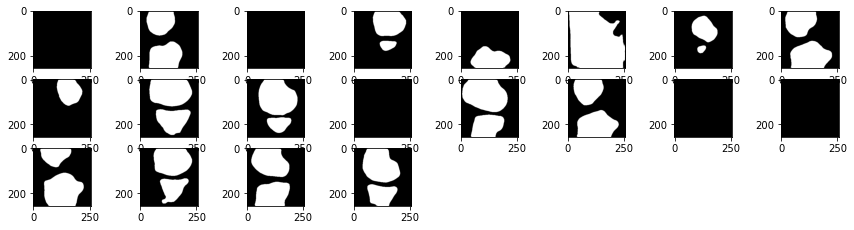

[0 1]


In [44]:
plot_examples(results_thresh[0:20])

print(np.unique(results_thresh))

In [95]:
# create a new results folder
results_path = testimage_path+'Multiclass_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss' 
os.mkdir(results_path)

In [98]:
# save all images in the new results folder. change the file names as you see fit but they are currently set up to keep their same original file name to ensure you're saving the right subject and slice

for i in range(len(results_thresh)):
    io.imsave(os.path.join(results_path, 'predictedmask.'+file_names_testimages[i]), results_thresh[i])
#    io.imsave(os.path.join(results_path, 'predictedmask_thresh_512.'+file_names_testimages[i]), results_thresh_512[i])
#    io.imsave(os.path.join(results_path, 'predictedmask_y_test_MRI.'+file_names_testimages[i]), all_combined[i])
#    io.imsave(os.path.join(results_path, 'X_test.'+file_names_testimages[i]), X_test[i])
#    io.imsave(os.path.join(results_path, 'y_test.'+file_names_testimages[i]), y_test[i])

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.BMI018RTpre-0115.bmp is a low contrast image
  after removing the cwd from sys.path.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0056.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_lau

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0035.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0050.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 p

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0036.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0090.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 pr

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0101.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0030.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 p

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.BMI018RTpre-0037.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0068.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prio

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.BMI018RTpre-0107.bmp is a low contrast image
  after removing the cwd from sys.path.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0088.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_lau

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0079.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0039.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0010.bmp is a low contrast image
  after removing the cwd from sys.path.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0073.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_la

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0061.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0028.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0120.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0039.bmp is a low contrast image


/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0092.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0033.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 p

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.BMI018RTpre-0020.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0044.bmp is a low contrast image
  

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.BMI018RTpre-0083.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0040.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 pri

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0032.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0106.bmp is a low contrast imag

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.BMI018RTpre-0067.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0029.bmp is a low contrast image
  

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0058.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.BMI018RTpre-0078.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 pri

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0020.bmp is a low contrast image
  after removing the cwd from sys.path.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0059.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.BMI018RTpre-0001.bmp is a low contrast image
  after removing the cwd from sys.path.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.BMI018RTpre-0106.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior 

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0047.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.BMI018RTpre-0030.bmp is a low contrast image
  

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0013.bmp is a low contrast image
  after removing the cwd from sys.path.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.69F025D20LtPre-0069.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_l

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.CSACL070RTPre-0117.bmp is a low contrast image
  after removing the cwd from sys.path.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/Validation_bitmaps/XXXMulticlass_Results_df8_trainbatch16_testbatch4_ep15_catcrossentropy/predictedmask_argmax_no_thresh.BMI018RTpre-0002.bmp is a low contrast image
  after removing the cwd from sys.path.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Combined/V

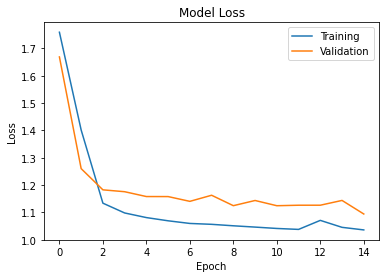

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.savefig('Loss_per_epoch_plot.png')
plt.show()